# Influence functions for data mislabeling


Data mislabeling occurs whenever some examples from a usually big dataset are wrongly-labeled. This hardly violates the assumption that the data distribution of the data equals the hidden distribution of the real world. Hence, it is important to be able to restore such datasets automatically. In real-life scenarios, this happens fairly often and can have various reasons, e.g. problems with identifiability, human error, or noise in the data. Imagine a simple classification problem

$$
\begin{align*}
x_i &\in \mathbb{R}^d \\
y_i &\in \{0, 1\} \\
\forall i &\in [ N ]
\end{align*}
$$

containing $N$ samples. A classical example is whether a patient has a disease or not based on some feature representation $x$ of that person. Furthermore, this formalism applies to all datasets, which can be transformed to a vector of size $d$ by either linearization or other embedding techniques. For the described model the optimal decision boundary can be derived manually. This showed to be advantageous for educational purposes. Using a Bernoulli distribution on the classes $y$ and for the features $x$ a Gaussian distribution conditioned on the previous samples class label $y$. This can be formalized as a graphical model

$$
y_i \sim \text{Ber}\left (0.5 \right) \\
x_i \sim \mathcal{N}\left ((1 - y_i) \mu_1 + y_i \mu_2, \sigma^2 I \right),
$$

with fixed means and diagonal covariance. Implementing the sampling scheme in python is straightforward and can be achieved by first sampling $y$ and afterward $x$. More formally $x$ is a function of $y$ and not vice versa. The following code snippet

In [1]:
import numpy as np
from valuation.utils.numeric import sample_classification_dataset_using_gaussians

num_samples = 10000
num_features = 2
sigma = 0.2
mus = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])

num_classes = len(mus)
x, y = sample_classification_dataset_using_gaussians(mus, sigma, num_samples)

generates the aforementioned dataset. After the dataset was generated, a closer inspection of the data is performed. The following code snippet explicitly calculates

In [2]:
from valuation.utils import decision_boundary_fixed_variance_2d

decision_boundary_fn = decision_boundary_fixed_variance_2d(mus[0], mus[1])
decision_boundary = decision_boundary_fn(np.linspace(-1.5, 1.5, 100))

 the decision boundary by mapping a continuous line of z values to a 2-dimensional vector in feature space. For more information view appendix A.

## Plotting the dataset
Next step consists in wrapping the previously generated data into a dataset with separate training and test set.

In [3]:
from sklearn.model_selection import train_test_split
from valuation.utils import Dataset

arg_flipper = lambda x1, x2, y1, y2: (x1, y1, x2, y2) # hacky
dataset = Dataset(*arg_flipper(*train_test_split(x, y, train_size=0.70)))

Subsequently, the data is plotted with their respective class labels 0 or 1.

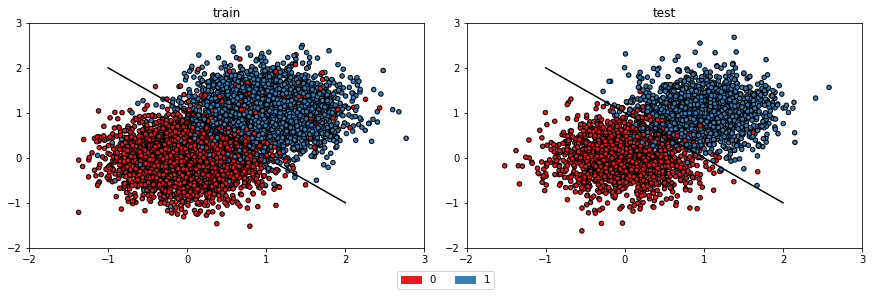

In [12]:
from valuation.utils.plotting import plot_datasets

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
x_min = np.asarray([-2, -2])
x_max = np.asarray([3, 3])
plot_datasets(datasets, x_min=x_min, x_max=x_max, line=decision_boundary, s=20)

Note that both the train and test set are plotted side by side and the training samples overlap with the optimal decision boundary. These samples would get wrongly by any discriminator as this region has some identifiability issues.

## Calculating influences using different reduction operators

This section cares about how to calculate influences for this dataset under the assumption of using a logistic regression model for inferring the right labels. Using the pyDVL valuation library a model can be formalized and fitted by using just a few lines of code.

In [5]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(num_features),
    objective=F.binary_cross_entropy,
    num_epochs=100,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM_W,
    optimizer_kwargs={
        "lr": 0.005,
        "weight_decay": 0.005
    },
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

It is important that the model converges to a point near the optimum, or otherwise the influence values will be of bad quality. Next the influences with respect to the previously fitted logistic regression model are calculated. A influence function

$$I(x_1, y_1, x_2, y_2) \colon \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$$

measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$ trough some model parameters $\theta$. As long as the loss function L is differentiable (or can be approximated by a surrogate objective) the influences

$$
I(x_1, x_2) = \nabla_\theta\; L(x_1, y_1) ^\mathsf{T} \; H_\theta^{-1} \; \nabla_\theta \; L(x_2, y_2)
$$

can be linearly approximated. Using the pyDVL library the influences can be estimated by the following snippet

In [6]:
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
train_influences = influences(
    model,
    dataset.x_train,
    dataset.y_train,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)
test_influences = influences(
    model,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)

using autograd and explicit construction of the Hessian. Recall the train influences have shape [NxM] where N is the number of test samples and M is the number of training samples. The keene reader notices that, in order to obtain a valid ranking for the training data, each column of the aforementioned matrix has to be reduced to a single value, resulting overall in an vector of size [M]. There are various different choices in order to select See also appendix B. This notebook restricts to use the mean absolute influence to filter for the wrong data labels. After calculating

In [7]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

the data is again visualized along with their influences.

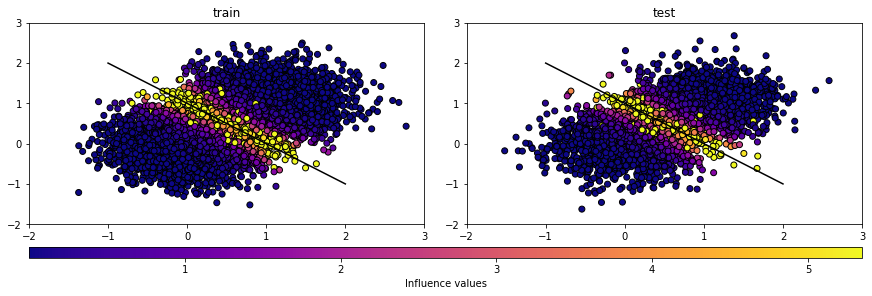

In [8]:
influence_datasets = {
    'train': (dataset.x_train, mean_train_influences),
    'test': (dataset.x_test, mean_test_influences),
}
plot_datasets(influence_datasets, x_min=x_min, x_max=x_max, line=decision_boundary)

## Flipping 5% of the training dataset and restore almost 80% of the flipped samples

It is assumed that our reference test set is not flipped and was checked. Usually this is a viable solution as the test set is much smaller than the train set. First 5% of the training set get flipped at random positions. Second it is shown how to identify these examples. So a flipped dataset is created by

In [9]:
from valuation.utils import flip_dataset

flipped_dataset, flipped_idx = flip_dataset(dataset, flip_percentage=0.05)

sampling random indices and inverting those. It is noteworthy to say that a new model has to fitted, because otherwise the old model contains information about the correct label of the specific data samples. Hence,

In [10]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

flipped_model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(num_features),
    objective=F.binary_cross_entropy,
    num_epochs=100,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM_W,
    optimizer_kwargs={
        "lr": 0.005,
        "weight_decay": 0.005
    },
)
flipped_model.fit(
    flipped_dataset.x_train,
    flipped_dataset.y_train
)

a new model is fitted with the pyDVL library. The newly obtained model is then used along with the flipped dataset to obtain the influences. Recall the aforementioned influence metrics and more specifically the mean absolute influence. For each training sample this metric is calculated and the 5% data points with the highest associated metric are extracted.

In [20]:
flipped_train_test_influences = influences(
    flipped_model,
    flipped_dataset.x_train,
    flipped_dataset.y_train,
    flipped_dataset.x_test,
    flipped_dataset.y_test,
    influence_type=InfluenceTypes.Up
)
mean_flipped_train_test_influences = mean_influences(flipped_train_test_influences)
estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(flipped_idx)]
found_elements = set(estimated_idx).intersection(set(flipped_idx))
remaining_element = set(flipped_idx).difference(set(estimated_idx))
f"Around {100* len(found_elements) / len(flipped_idx):.2f}% could be identified. But there are {100* len(remaining_element) / len(flipped_idx):.2f}% remaining samples"

'Around 74.00% could be identified. But there are 26.00% remaining samples'

 Furthermore, the accuracy is evaluated, e.g. the number of same elements in the ground truth and the detected samples. Depending on the dataset a detection of up to 80% percent could be achieved. One might further inspect the selection method for the indices as it only selects the highest influence points as flipped samples. Furthermore, it is unclear how flipping all samples back and retraining the model affects the loss of the initial dataset. Last but not least the remaining elements are inspected

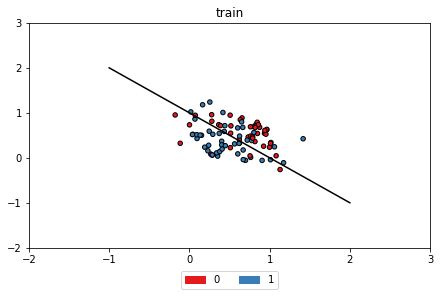

In [21]:
remaining_element = np.asarray(list(remaining_element), dtype=int)
remaining_datasets = {
    'train': (flipped_dataset.x_train[remaining_element], flipped_dataset.y_train[remaining_element])
}
plot_datasets(remaining_datasets, x_min=x_min, x_max=x_max, line=decision_boundary, s=20)

and indeed as expected the not identifiable examples lie around the decision boundary. This concludes the analysis and it was shown, that influence functions are a potential candidate for filtering wrongly labelled data.

# Appendix

## Appendix A: Calculating the decision boundary

For obtaining the optimal discriminator one has to solve the equation

$$p(x|y=0)=p(x|y=1)$$

and determine the solution set $X$. A closed-form solution can be found, if the pdf of both classes can be written in closed form. In the general case, this decision boundary must not be linear. However, in the case of two Gaussians

$$
\begin{align*}
p(x|y=0)&=\mathcal{N}\left (\mu_1, \sigma^2 I \right) \\
p(x|y=1)&=\mathcal{N}\left (\mu_2, \sigma^2 I \right)
\end{align*}
$$

the boundary is linear and is straightforward to derive it. The complete case with different full covariances is left to the reader as an exercise. For a single fixed diagonal variance parameterized by $\sigma$ the equation can be directly rewritten as

$$
\begin{align*}
\| x - \mu_1 \|^2 &= \| x - \mu_2 \|^2 \\
\| \mu_1 \|^2 -2 x^\mathsf{T} \mu_1 &= \| \mu_2 \|^2 -2 x^\mathsf{T} \mu_2 \\
\implies 0 &= 2 (\mu_2 - \mu_1)^\mathsf{T} x + \| \mu_1 \|^2 - \| \mu_2 \|^2 \\
0 &= \mu_1^\mathsf{T}x - \mu_2^\mathsf{T}x - \frac{1}{2} \mu_1^\mathsf{T} \mu_1 + \frac{1}{2} \mu_2^\mathsf{T} \mu_2
\end{align*}
$$

by using linear decision theory (see [Bishop C. 2006] for more details). However, this implicit description has to be transferred to an explicit one to effectively use it in python. Solving for the explicit form can be achieved by enforcing a functional form $f(z) = x = a z + b$ with $z \in \mathbb{R}$ onto $x$. After the term is inserted in the previous equation

$$
0 = (\mu_2 - \mu_1)^\mathsf{T} (az + b) + \frac{1}{2} \| \mu_1 \|^2 - \| \mu_2 \|^2
$$

by setting $a$ to be explicitly orthogonal to $\mu_2 - \mu_1$ and then solving for $b$ the solution

$$
f(z) = \underbrace{\begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} (\mu_2 - \mu_1)}_a z + \underbrace{\frac{\mu_1 + \mu_2}{2}}_b
$$

for the functional form $f(z) = a z + b$ can be obtained.

## Appendix B: Different influence aggregation methods

A few strictly positive sample metrics

$$
\begin{align*}
\text{MAI}(x) &= \frac{1}{N} \sum_{i=1}^N | I(x, x_i) | \\
\text{PMAI}(x) &= \frac{1}{N} \sum_{i=1}^N \max(0, I(x, x_i))  \\
\text{NMAI}(x) &= \frac{1}{N} \sum_{i=1}^N \max(0, -I(x, x_i))
\end{align*}
$$

are given. Note the functional relation $\text{MAI}(x) = \text{PMAI}(x) + \text{NMAI}(x)$.